# County-level agricultural variables analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import earthpy.clip as ec

import scipy.stats as ss
from sklearn.metrics import r2_score

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")[::-1]
cork_map = LinearSegmentedColormap.from_list("Broc", cm_data)
cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/batlow/batlow.txt")
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

## Everything we need

### County shapefile

In [2]:
# Get county shapefile
county = gp.read_file("../../../large_files/contig_county/counties_contig.shp")
county["GEOID"] = county["GEOID"].astype(str).str.zfill(5)

In [3]:
states = gp.read_file("../../../large_files/contig_states/CONUS_states.shp")

In [4]:
coast = gp.read_file("../../../data/conus_dissolved/usa-boundary-dissolved.shp")

### GMFD "Ground Truth"

In [93]:
# GMFD
gmfd = pd.read_csv("../../model_results/data/agvar_historical_gmfd.csv")
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)

# Merge with county shapefile
gmfd_shp = pd.merge(county, gmfd.reset_index(), on = "GEOID", how = "outer", copy = False).drop(columns = ["STATEFP","COUNTYFP"])
gmfd_shp.set_index(["GEOID", "NAME", "Year"], inplace = True)

In [84]:
gmfd_shp.head()

geometry  index  \
GEOID NAME   Year                                                             
31039 Cuming 1956  POLYGON ((-97.019516 42.004097, -97.019519 42....      0   
             1957  POLYGON ((-97.019516 42.004097, -97.019519 42....      1   
             1958  POLYGON ((-97.019516 42.004097, -97.019519 42....      2   
             1959  POLYGON ((-97.019516 42.004097, -97.019519 42....      3   
             1960  POLYGON ((-97.019516 42.004097, -97.019519 42....      4   

                           gdd       egdd      prcp  
GEOID NAME   Year                                    
31039 Cuming 1956  1511.181607  57.201641  0.362867  
             1957  1436.631185  46.470627  0.498077  
             1958  1327.679602  21.887867  0.479633  
             1959  1510.308176  38.535865  0.644508  
             1960  1377.638260  28.172491  0.561391

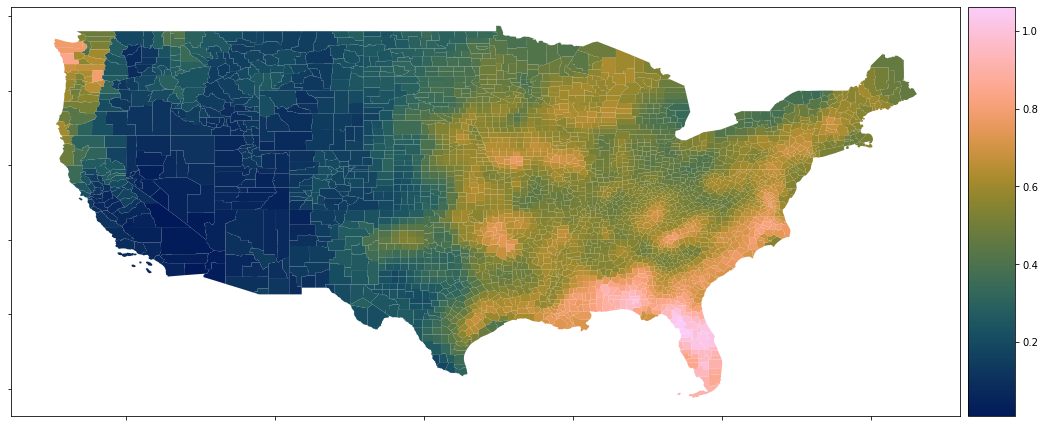

In [7]:
# GMFD
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gmfd_shp.query("Year == 1960").plot(column = "prcp", ax = ax, cax = cax, legend = True, cmap = batlow_map)
ax.tick_params(labelbottom=False, labelleft = False)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

In [95]:
# Split ag variables
temp1 = gmfd.drop(columns = ["egdd","prcp"])
temp1["AgVar"] = "gdd"
temp1.rename(columns = {"gdd" : "GMFD"}, inplace = True)
temp1.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp2 = gmfd.drop(columns = ["gdd","prcp"])
temp2["AgVar"] = "egdd"
temp2.rename(columns = {"egdd" : "GMFD"}, inplace = True)
temp2.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp3 = gmfd.drop(columns = ["gdd","egdd"])
temp3["AgVar"] = "prcp"
temp3.rename(columns = {"prcp" : "GMFD"}, inplace = True)
temp3.set_index(["AgVar", "GEOID", "Year"], inplace = True)

# Join with updated indexing
gmfd = temp1.append(temp2).append(temp3)

In [98]:
gmfd.head()

GMFD
AgVar GEOID Year             
gdd   31039 1956  1511.181607
            1957  1436.631185
            1958  1327.679602
            1959  1510.308176
            1960  1377.638260

## Hindcasts

In [109]:
nex_hind = ["agvar_historical_r1i1p1_ACCESS1-0.csv",
"agvar_historical_r1i1p1_BNU-ESM.csv",
"agvar_historical_r1i1p1_CCSM4.csv",
"agvar_historical_r1i1p1_CESM1-BGC.csv",
"agvar_historical_r1i1p1_CNRM-CM5.csv",
"agvar_historical_r1i1p1_CSIRO-Mk3-6-0.csv",
"agvar_historical_r1i1p1_CanESM2.csv",
"agvar_historical_r1i1p1_GFDL-CM3.csv",
"agvar_historical_r1i1p1_GFDL-ESM2G.csv",
"agvar_historical_r1i1p1_GFDL-ESM2M.csv",
"agvar_historical_r1i1p1_IPSL-CM5A-LR.csv",
"agvar_historical_r1i1p1_IPSL-CM5A-MR.csv",
"agvar_historical_r1i1p1_MIROC-ESM-CHEM.csv",
"agvar_historical_r1i1p1_MIROC-ESM.csv",
"agvar_historical_r1i1p1_MIROC5.csv",
"agvar_historical_r1i1p1_MPI-ESM-LR.csv",
"agvar_historical_r1i1p1_MPI-ESM-MR.csv",
"agvar_historical_r1i1p1_MRI-CGCM3.csv",
"agvar_historical_r1i1p1_NorESM1-M.csv",
"agvar_historical_r1i1p1_bcc-csm1-1.csv",
"agvar_historical_r1i1p1_inmcm4.csv"]

cmip_all = ["agvar_ACCESS1-0.historical+rcp85.csv",
"agvar_BNU-ESM.historical+rcp85.csv",
"agvar_CCSM4_historical+rcp85.csv",
"agvar_CESM1-BGC.historical+rcp85.csv",
"agvar_CNRM-CM5.historical+rcp85.csv",
"agvar_CSIRO-Mk3-6-0.historical+rcp85.csv",
"agvar_CanESM2.historical+rcp85.csv",
"agvar_GFDL-CM3.historical+rcp85.csv",
"agvar_GFDL-ESM2G.historical+rcp85.csv",
"agvar_GFDL-ESM2M.historical+rcp85.csv",
"agvar_IPSL-CM5A-LR.historical+rcp85.csv",
"agvar_IPSL-CM5A-MR.historical+rcp85.csv",
"agvar_MIROC-ESM-CHEM.historical+rcp85.csv",
"agvar_MIROC-ESM.historical+rcp85.csv",
"agvar_MIROC5.historical+rcp85.csv",
"agvar_MPI-ESM-LR.historical+rcp85.csv",
"agvar_MPI-ESM-MR.historical+rcp85.csv",
"agvar_MRI-CGCM3.historical+rcp85.csv",
"agvar_NorESM1-M.historical+rcp85.csv",
"agvar_bcc-csm1-1_historical+rcp85.csv",
"agvar_inmcm4.historical+rcp85.csv"]

In [110]:
# Get nex models
nex  = pd.read_csv("../../model_results/data/nex/" + nex_hind[0])
nex["GEOID"] = nex["GEOID"].astype(str).str.zfill(5)

# Split ag variables
temp1 = nex.drop(columns = ["egdd","prcp"])
temp1["AgVar"] = "gdd"
temp1.rename(columns = {"gdd" : nex_hind[0].replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp1.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp2 = nex.drop(columns = ["gdd","prcp"])
temp2["AgVar"] = "egdd"
temp2.rename(columns = {"egdd" : nex_hind[0].replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp2.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp3 = nex.drop(columns = ["gdd","egdd"])
temp3["AgVar"] = "prcp"
temp3.rename(columns = {"prcp" : nex_hind[0].replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp3.set_index(["AgVar", "GEOID", "Year"], inplace = True)

# Join with updated indexing
nex = temp1.append(temp2).append(temp3)

for name in nex_hind[1:]:
    # Read in product
    data = pd.read_csv("../../model_results/data/nex/" + name)
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    model = name.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")
    
    # Split & join
    temp1 = data.drop(columns = ["egdd","prcp"])
    temp1["AgVar"] = "gdd"
    temp1.rename(columns = {"gdd" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp1.set_index(["AgVar", "GEOID", "Year"], inplace = True)
    
    temp2 = data.drop(columns = ["gdd","prcp"])
    temp2["AgVar"] = "egdd"
    temp2.rename(columns = {"egdd" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp2.set_index(["AgVar", "GEOID", "Year"], inplace = True)
    
    temp3 = data.drop(columns = ["gdd","egdd"])
    temp3["AgVar"] = "prcp"
    temp3.rename(columns = {"prcp" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp3.set_index(["AgVar", "GEOID", "Year"], inplace = True)

    temp = temp1.append(temp2).append(temp3)
    
    # Do the merge
    print("Now merging... " + model)
    nex = pd.merge(nex, temp, on = ["AgVar", "GEOID", "Year"], how = "outer")
    print("Merge complete.")

Now merging... BNU-ESM
Merge complete.
Now merging... CCSM4
Merge complete.
Now merging... CESM1-BGC
Merge complete.
Now merging... CNRM-CM5
Merge complete.
Now merging... CSIRO-Mk3-6-0
Merge complete.
Now merging... CanESM2
Merge complete.
Now merging... GFDL-CM3
Merge complete.
Now merging... GFDL-ESM2G
Merge complete.
Now merging... GFDL-ESM2M
Merge complete.
Now merging... IPSL-CM5A-LR
Merge complete.
Now merging... IPSL-CM5A-MR
Merge complete.
Now merging... MIROC-ESM-CHEM
Merge complete.
Now merging... MIROC-ESM
Merge complete.
Now merging... MIROC5
Merge complete.
Now merging... MPI-ESM-LR
Merge complete.
Now merging... MPI-ESM-MR
Merge complete.
Now merging... MRI-CGCM3
Merge complete.
Now merging... NorESM1-M
Merge complete.
Now merging... bcc-csm1-1
Merge complete.
Now merging... inmcm4
Merge complete.


In [111]:
# Get cmip models
cmip  = pd.read_csv("../../model_results/data/cmip/" + cmip_all[0])
cmip["GEOID"] = cmip["GEOID"].astype(str).str.zfill(5)

# Split ag variables
temp1 = cmip.drop(columns = ["egdd","prcp"])
temp1["AgVar"] = "gdd"
temp1.rename(columns = {"gdd" : cmip_all[0].replace(".historical+rcp85","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp1.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp2 = cmip.drop(columns = ["gdd","prcp"])
temp2["AgVar"] = "egdd"
temp2.rename(columns = {"egdd" : cmip_all[0].replace(".historical+rcp85","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp2.set_index(["AgVar", "GEOID", "Year"], inplace = True)

temp3 = cmip.drop(columns = ["gdd","egdd"])
temp3["AgVar"] = "prcp"
temp3.rename(columns = {"prcp" : cmip_all[0].replace(".historical+rcp85","").replace(".csv","").replace("agvar_","")}, inplace = True)
temp3.set_index(["AgVar", "GEOID", "Year"], inplace = True)

# Join with updated indexing
cmip = temp1.append(temp2).append(temp3)

for name in cmip_all[1:]:
    # Read in product
    data = pd.read_csv("../../model_results/data/cmip/" + name)
    data["GEOID"] = data["GEOID"].astype(str).str.zfill(5)
    model = name.replace(".historical+rcp85","").replace(".csv","").replace("agvar_","").replace("_historical+rcp85","")
    
    # Split & join
    temp1 = data.drop(columns = ["egdd","prcp"])
    temp1["AgVar"] = "gdd"
    temp1.rename(columns = {"gdd" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp1.set_index(["AgVar", "GEOID", "Year"], inplace = True)
    
    temp2 = data.drop(columns = ["gdd","prcp"])
    temp2["AgVar"] = "egdd"
    temp2.rename(columns = {"egdd" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp2.set_index(["AgVar", "GEOID", "Year"], inplace = True)
    
    temp3 = data.drop(columns = ["gdd","egdd"])
    temp3["AgVar"] = "prcp"
    temp3.rename(columns = {"prcp" : model.replace("historical_r1i1p1_","").replace(".csv","").replace("agvar_","")}, inplace = True)
    temp3.set_index(["AgVar", "GEOID", "Year"], inplace = True)

    temp = temp1.append(temp2).append(temp3)
    
    # Do the merge
    print("Now merging... " + model)
    cmip = pd.merge(cmip, temp, on = ["AgVar", "GEOID", "Year"], how = "outer")
    print("Merge complete.")

Now merging... BNU-ESM
Merge complete.
Now merging... CCSM4
Merge complete.
Now merging... CESM1-BGC
Merge complete.
Now merging... CNRM-CM5
Merge complete.
Now merging... CSIRO-Mk3-6-0
Merge complete.
Now merging... CanESM2
Merge complete.
Now merging... GFDL-CM3
Merge complete.
Now merging... GFDL-ESM2G
Merge complete.
Now merging... GFDL-ESM2M
Merge complete.
Now merging... IPSL-CM5A-LR
Merge complete.
Now merging... IPSL-CM5A-MR
Merge complete.
Now merging... MIROC-ESM-CHEM
Merge complete.
Now merging... MIROC-ESM
Merge complete.
Now merging... MIROC5
Merge complete.
Now merging... MPI-ESM-LR
Merge complete.
Now merging... MPI-ESM-MR
Merge complete.
Now merging... MRI-CGCM3
Merge complete.
Now merging... NorESM1-M
Merge complete.
Now merging... bcc-csm1-1
Merge complete.
Now merging... inmcm4
Merge complete.


### Calculation

In [423]:
# Stats calulator
def analyse_RMSE_gmfd(data):
    # Merge with gmfd
    data_all = pd.merge(data.reset_index(), gmfd.reset_index(), left_on = ["AgVar","GEOID","Year"], right_on = ["AgVar","GEOID","Year"], how = "inner", copy = False)

    data_all.set_index(["AgVar","GEOID","Year"], inplace = True)
    data_all["count"] = 1
    
    # Calculate RMSE and SD
    models = np.delete(data_all.columns.values, [np.where(data_all.columns.values == "count")])
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_all[model_RMSE] = (data_all[model] - data_all["GMFD"])**2
        data_all[model_nSD] = (data_all[model] - data_all[model].mean(level = ["AgVar", "GEOID"]))**2
        del data_all[model]
        
    data_an = data_all.groupby(["AgVar", "GEOID"]).sum()
    
    for model in models:
        model_RMSE = model + "_RMSE"
        model_nSD = model + "_nSD"
        data_an[model_RMSE] = data_an[model_RMSE] / data_an["count"]
        data_an[model_RMSE] = np.sqrt(data_an[model_RMSE])
        
        data_an[model_nSD] = data_an[model_nSD] / data_an["GMFD_nSD"]
        data_an[model_nSD] = np.sqrt(data_an[model_nSD])
    
    del data_an["count"]
    del data_an["GMFD_RMSE"]
    del data_an["GMFD_nSD"]
    
    return data_an

In [424]:
########################### NEX
# Add ensemble mean
nex["ensemble_mean"] = nex.mean(axis = 1)

# Calculate RMSE with GMFD
nex_gmfd_an = analyse_RMSE_gmfd(nex)
# Merge with county shapefile
nex_gmfd_shp = pd.merge(county.drop(columns = ["STATEFP","COUNTYFP","NAME"]), nex_gmfd_an.reset_index(), on = "GEOID", how = "outer", copy = False)
nex_gmfd_shp.set_index(["AgVar","GEOID"], inplace = True)
nex_gmfd_shp.sort_index(inplace = True)

In [426]:
########################### CMIP
# Add ensemble mean
cmip["ensemble_mean"] = cmip.mean(axis = 1)

# Calculate RMSE with GMFD
cmip_gmfd_an = analyse_RMSE_gmfd(cmip)
# Merge with county shapefile
cmip_gmfd_shp = pd.merge(county.drop(columns = ["STATEFP","COUNTYFP","NAME"]), cmip_gmfd_an.reset_index(), on = "GEOID", how = "outer", copy = False)
cmip_gmfd_shp.set_index(["AgVar","GEOID"], inplace = True)
cmip_gmfd_shp.sort_index(inplace = True)

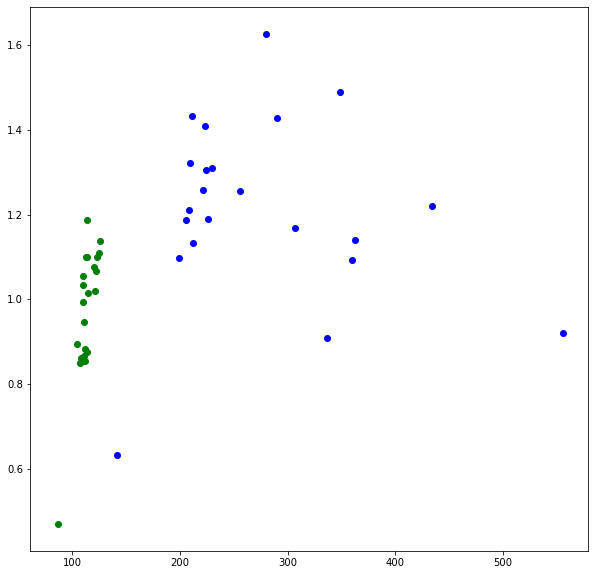

In [466]:
# GDD improvement
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.scatter(cmip_gmfd_an.groupby("AgVar").mean().loc["gdd"][::2],cmip_gmfd_an.groupby("AgVar").mean().loc["gdd"][1::2],c = "Blue")
plt.scatter(nex_gmfd_an.groupby("AgVar").mean().loc["gdd"][::2],nex_gmfd_an.groupby("AgVar").mean().loc["gdd"][1::2],c = "Green")
plt.show()

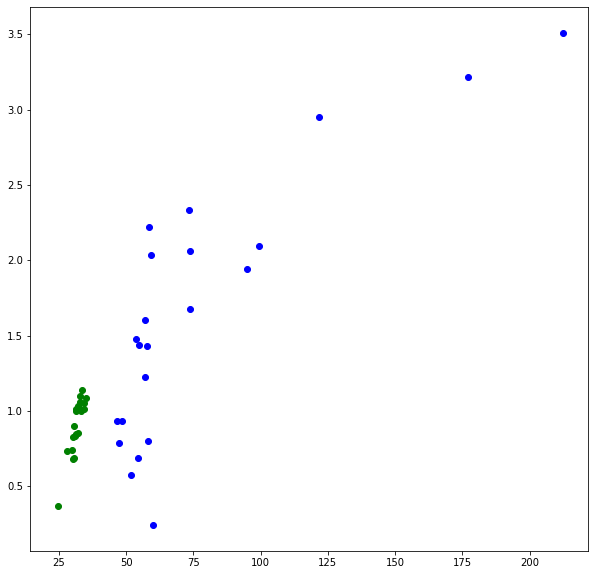

In [467]:
# egdd improvement
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.scatter(cmip_gmfd_an.groupby("AgVar").mean().loc["egdd"][::2],cmip_gmfd_an.groupby("AgVar").mean().loc["egdd"][1::2],c = "Blue")
plt.scatter(nex_gmfd_an.groupby("AgVar").mean().loc["egdd"][::2],nex_gmfd_an.groupby("AgVar").mean().loc["egdd"][1::2],c = "Green")
plt.show()

In [ ]:
# # Update CRS for better US shape
# nex_shp = nex_shp.to_crs({'init': 'epsg:2163'})
# cmip_shp = cmip_shp.to_crs({'init': 'epsg:2163'})
# coast = coast.to_crs({'init': 'epsg:2163'})
# states = states.to_crs({'init': 'epsg:2163'})

# # Clip 
# nex_shp = ec.clip_shp(nex_shp, coast.envelope)
# nex_shp.crs = {'init': 'epsg:2163'}
# nex_shp = gp.overlay(nex_shp, states, how = "intersection")

# cmip_shp = ec.clip_shp(cmip_shp, coast.envelope)
# cmip_shp.crs = {'init': 'epsg:2163'}
# cmip_shp = gp.overlay(cmip_shp, states, how = "intersection")

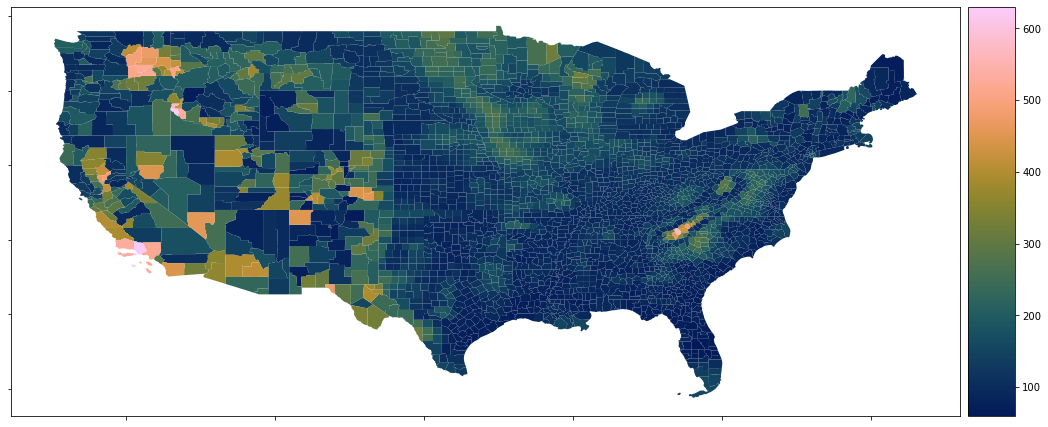

In [191]:
# CMIP gdd RMSE
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmip_gmfd_shp.loc["gdd"].plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map)
ax.tick_params(labelbottom=False, labelleft = False)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

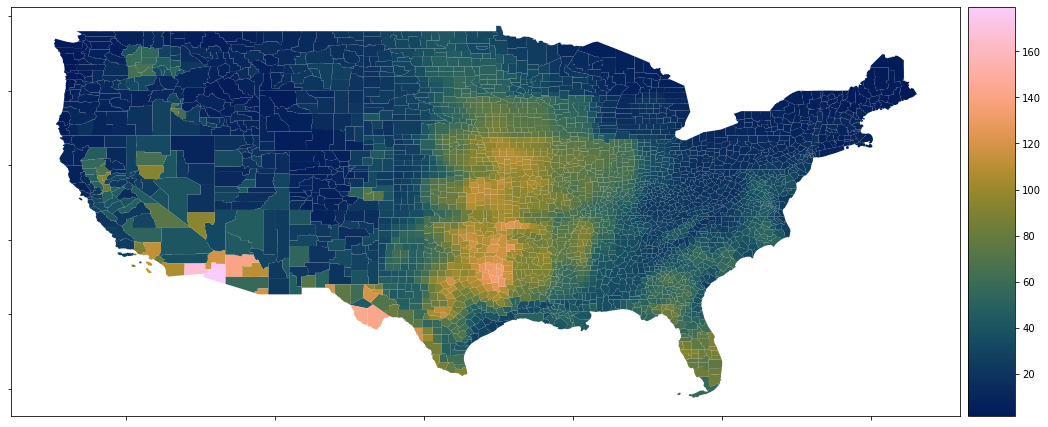

In [193]:
# CMIP egdd RMSE
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmip_gmfd_shp.loc["egdd"].plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map)
ax.tick_params(labelbottom=False, labelleft = False)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

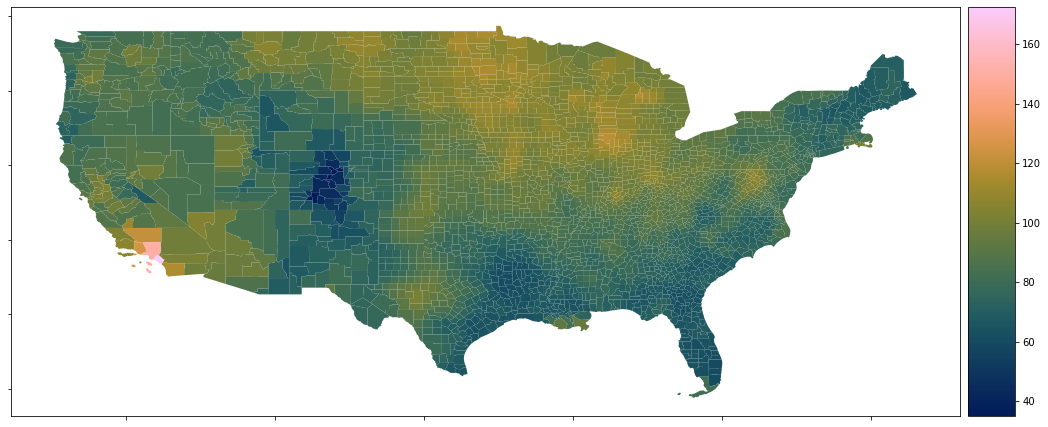

In [192]:
# NEX gdd RMSE
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
nex_gmfd_shp.loc["gdd"].plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map)
ax.tick_params(labelbottom=False, labelleft = False)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

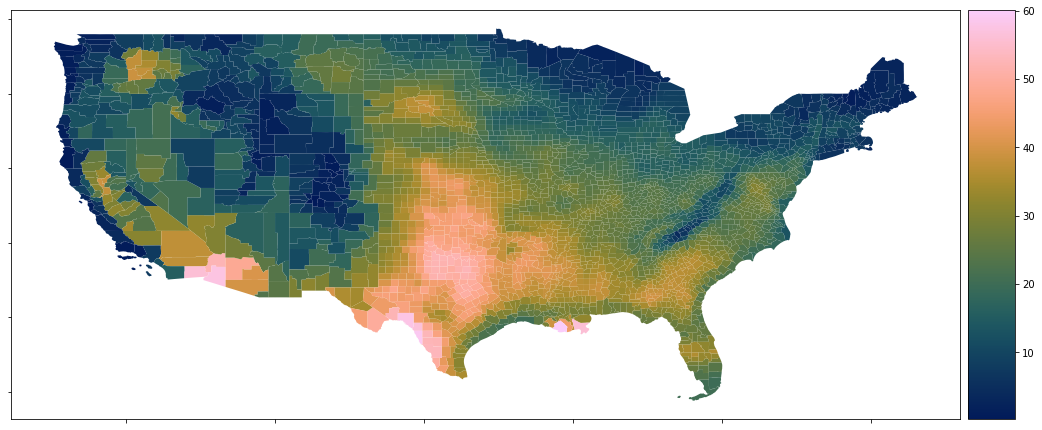

In [194]:
# NEX egdd RMSE
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
nex_gmfd_shp.loc["egdd"].plot(column = "ensemble_mean_RMSE", ax = ax, cax = cax, legend = True, cmap = batlow_map)
ax.tick_params(labelbottom=False, labelleft = False)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.show()

In [199]:
# NEX to CMIP ratios against GMFD
all_shp = pd.merge(nex_gmfd_shp.filter(["RMSE_mean", "GEOID", "geometry", "ensemble_mean_RMSE"]), cmip_gmfd_shp.filter(["RMSE_mean", "GEOID", "ensemble_mean_RMSE"]), on = ["AgVar", "GEOID"], suffixes=("_NEX", "_CMIP"))
all_shp["RMSE_mean_ratio"] = all_shp["RMSE_mean_NEX"] / all_shp["RMSE_mean_CMIP"]
all_shp["ensemble_mean_RMSE_ratio"] = all_shp["ensemble_mean_RMSE_NEX"] / all_shp["ensemble_mean_RMSE_CMIP"]

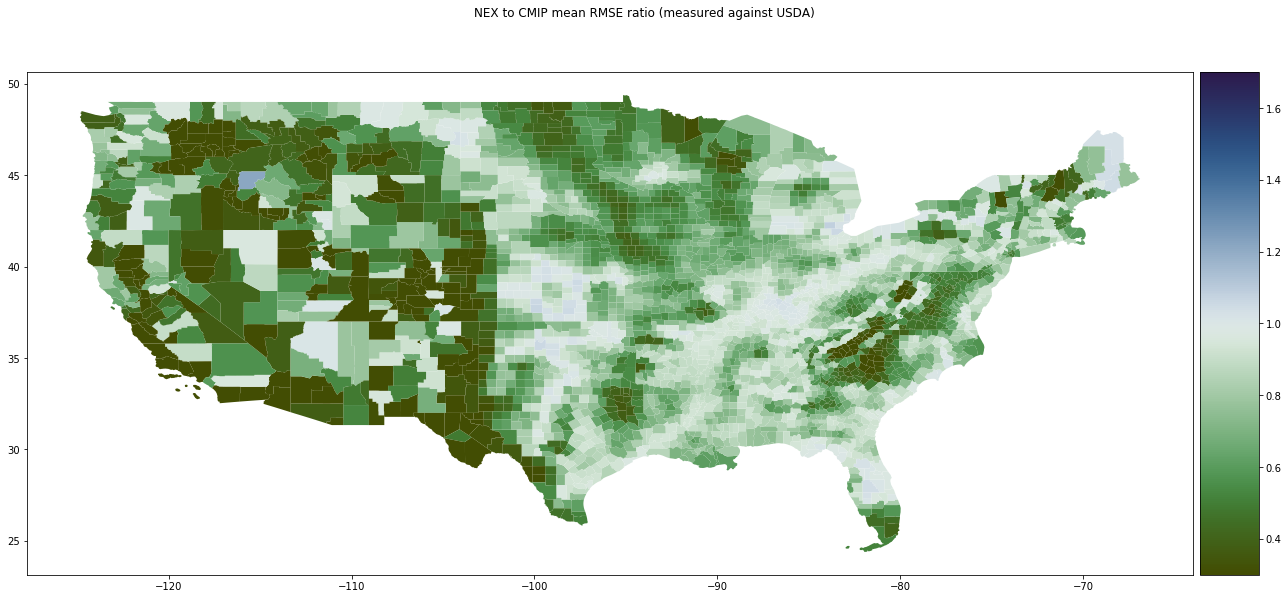

In [208]:
# gdd Ensemble mean ratio 
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.loc["gdd"].plot(column = "ensemble_mean_RMSE_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.3, vmax = 1.7)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.show()

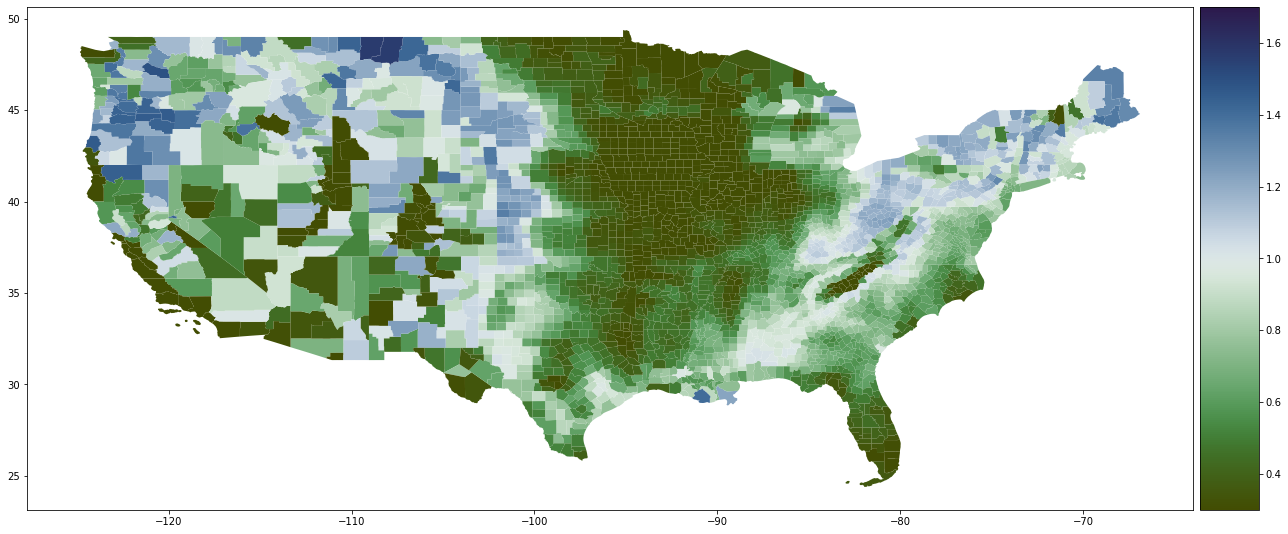

In [210]:
# egdd Ensemble mean ratio 
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.loc["egdd"].plot(column = "ensemble_mean_RMSE_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.3, vmax = 1.7)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.show()

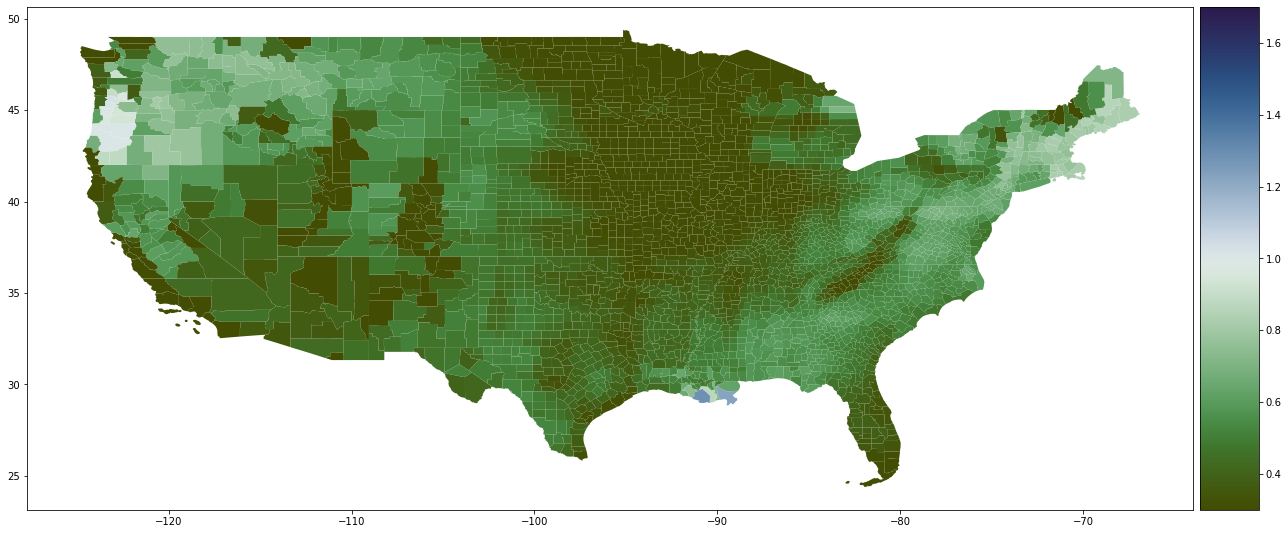

In [211]:
# egdd mean RMSE ratio 
fig, ax = plt.subplots(1,1, figsize = (18,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
all_shp.loc["egdd"].plot(column = "RMSE_mean_ratio", ax = ax, cax = cax, legend = True, cmap=cork_map, vmin = 0.3, vmax = 1.7)
# states.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
# coast.geometry.boundary.plot(ax = ax, linewidth = 0.5, edgecolor = "black", color = None)
plt.tight_layout()
plt.show()